# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

# Install Packages
you may ignor the `WARNING` messages, or `ERROR` from pip!<br>
If your run this code on your laptop, you may not face any error, `briainiak` requires some specific dependencies.<br>
For furthur infromation about `brainiak` chek this <a href="https://brainiak.org/docs/index.html">Link</a>.


In [10]:
# @title Install dependencies and import
try:
    import brainiak
    print("Brainiak is already installed.")
except ImportError:
    print("Brainiak is not installed. Installing now...")
    !pip install brainiak --quiet



# List of packages to check and install
packages = ['numpy', 'pandas', 'seaborn', 'matplotlib','requests']

# Function to check and install packages
def check_and_install(package):
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing now...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '--quiet'])

# Check and install each package
for package in packages:
    check_and_install(package)


# Import the packages after installation
import os
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("All packages are successfully imported.")

Brainiak is already installed.
numpy is already installed.
pandas is already installed.
seaborn is already installed.
matplotlib is already installed.
requests is not installed. Installing now...
All packages are successfully imported.


In [6]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# Intilization
setting variables accordignto the HCP dataset (NMA version)

In [8]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [14]:
# @title Download data file

import os
import requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
    try:
        print(f"Attempting to download {fname} from {url}...")
        r = requests.get(url, timeout=10)  # Added timeout for better handling
        r.raise_for_status()  # Raises an HTTPError for bad responses (4xx or 5xx)
    except requests.ConnectionError:
        print("!!! Failed to connect to the server !!!")
    except requests.Timeout:
        print("!!! The request timed out !!!")
    except requests.HTTPError as http_err:
        print(f"!!! HTTP error occurred: {http_err} !!!")
    except Exception as err:
        print(f"!!! An error occurred: {err} !!!")
    else:
        with open(fname, "wb") as fid:
            fid.write(r.content)
        print(f"Successfully downloaded {fname}.")
else:
    print(f"{fname} already exists. No need to download.")


Attempting to download hcp_task.tgz from https://osf.io/2y3fw/download...
!!! Failed to connect to the server !!!


In [6]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)

## Understanding the EV Files
Refer to EV.txt file

# Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [7]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Gambler Definition

The Class of Gambler, contains varibales and methods required for each subject<br>
The initial parametrs are set. <br>
check the cell titled as **First Level** as an exmaple use case.

In [8]:
class Gambeler:
    def __init__(self, subject):
        self.subject = subject
        self.N_RUNS = 2
        self.RUNS   = ['LR','RL']
        self.TR = 0.72
        self.EXPERIMENTS = {'GAMBLING': {'cond':['loss','win']}}
        self.HCP_DIR = "./hcp_task"



    def load_single_timeseries(self, run, remove_mean=True):
      """Load timeseries data for a single subject and single run.

      Args:
        subject (str):      subject ID to load
        experiment (str):   Name of experiment
        run (int):          (0 or 1)
        remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

      Returns
        ts (n_parcel x n_timepoint array): Array of BOLD data values

      """
      bold_run  = self.RUNS[run]
      bold_path = f"{self.HCP_DIR}/subjects/{self.subject}/GAMBLING/tfMRI_GAMBLING_{bold_run}"
      bold_file = "data.npy"
      ts = np.load(f"{bold_path}/{bold_file}")
      if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
      return ts


    def load_evs_run(self,run):
      """Load EVs (explanatory variables) data for one task experiment.

      Args:
        subject (str): subject ID to load
        experiment (str) : Name of experiment
        run (int): 0 or 1

      Returns
        evs (list of lists): A list of frames associated with each condition

      """
      frames_list = []
      frames_Neut = []
      task_key = f'tfMRI_GAMBLING_{self.RUNS[run]}'

      # For win.txt and loss.txt
      for cond in self.EXPERIMENTS['GAMBLING']['cond']:
        ev_file  = f"{self.HCP_DIR}/subjects/{self.subject}/GAMBLING/{task_key}/EVs/{cond}_event.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / self.TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / self.TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)

      # for Neural_events.txt
      ev_file  = f"{self.HCP_DIR}/subjects/{self.subject}/GAMBLING/{task_key}/EVs/neut_event.txt"
      ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
      ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
      # Determine when trial starts, rounded down
      start = np.floor(ev["onset"] / self.TR).astype(int)
      # Use trial duration to determine how many frames to include for trial
      duration = np.ceil(ev["duration"] / self.TR).astype(int)
      # Take the range of frames that correspond to this specific trial
      frames_neut = [s + np.arange(0, d) for s, d in zip(start, duration)]
      frames_Neut.append(frames_neut)

      return frames_list, frames_Neut

    def load_timeseries(self):
        """Function to load the bold signal for a given subject and task.

        Returns:
            numpy.ndarray: Matrix of timeseries data
        """
        run_first  = self.load_single_timeseries(run=0, remove_mean=True)
        second_run = self.load_single_timeseries(run=1, remove_mean=True)

        return np.hstack((run_first, second_run))

    def load_evs(self):
      """
      function to load events and trials of win, loss and neutral

      RETURN:

      win_loss_LR, neuts_LR, win_loss_RL, neuts_RL
      """

      win_loss_LR, neuts_LR  = self.load_evs_run(run=0)
      win_loss_RL, neuts_RL  = self.load_evs_run(run=1)

      return (win_loss_LR, neuts_LR, win_loss_RL, neuts_RL)

    @staticmethod
    def design_matrix(win_loss,neuts_win,neut_loss, run):
        """
        function to create design matrix for each given run

        RETURNS:

        Intercepts,NeutsWin,NeutsLoss,Wins,Losses,Runs
        """
        Win_Neuts_LR=list(neuts_LR[0][1])
        Loss_Neuts_LR=list(neuts_RL[0][0])



        # column2: Neuts in Win
        NeutsWin = np.zeros(253)

        for i in neuts_win:
          NeutsWin[i-1]=1


        # column3: Neuts in Loss
        NeutsLoss = np.zeros(253)

        for i in neut_loss:
          NeutsLoss[i-1]=1

        # column4: wins
        Wins     = np.zeros(253)
        Wins_tf  = win_loss[1]

        for i in range(len(Wins_tf)):
          for j in Wins_tf[i]:
            Wins[j-1]=1

        # column5: Losses
        Losses     = np.zeros(253)
        Losses_tf  = win_loss[0]

        for i in range(len(Losses_tf)):
          for j in Losses_tf[i]:
            Losses[j-1]=1


        # Columns 1:  Intercept
        Intercepts = np.ones(253)

        # Column6: Run
        if run:
          Runs = np.ones(253)
        else:
          Runs = np.zeros(253)

        return np.vstack((Intercepts,NeutsWin,NeutsLoss,Wins,Losses,Runs)).T

    @staticmethod
    def hrf_convolv(design_matrix):
      """ Function to calculate the HRF convolution for given design matrix

      RETURN:
        Covolved Design Matrix
      """
      c1=brainiak.utils.fmrisim.convolve_hrf(design_matrix[:,1].reshape(506,1), 0.72, hrf_type='double_gamma', scale_function=True, temporal_resolution=1.39)
      c2 =brainiak.utils.fmrisim.convolve_hrf(design_matrix[:,2].reshape(506,1), 0.72, hrf_type='double_gamma', scale_function=True, temporal_resolution=1.39)
      c3 = brainiak.utils.fmrisim.convolve_hrf(design_matrix[:,3].reshape(506,1), 0.72, hrf_type='double_gamma', scale_function=True, temporal_resolution=1.39)
      c4 = brainiak.utils.fmrisim.convolve_hrf(design_matrix[:,4].reshape(506,1), 0.72, hrf_type='double_gamma', scale_function=True, temporal_resolution=1.39)

      return np.hstack((design_matrix[:,0].reshape(506,1),c1,c2,c3,c4,design_matrix[:,5].reshape(506,1)))


    @staticmethod
    def OLS(x,y):
      beta = (np.linalg.inv((x.T)@x)) @ (x.T) @ y
      return beta


    @staticmethod
    def contrast(betas):
      """
      Calculate the contrast values from beta coefficients using a specified contrast vector.

      Args:
      betas (numpy.ndarray): Array of shape (n_voxels, n_betas) containing the beta coefficients.
      contrast_vector (numpy.ndarray): Array of shape (n_betas,) specifying the weights for each beta coefficient.

      Returns:
      numpy.ndarray: Array of shape (n_voxels,) containing the contrast values for each voxel.
      """
      # contrast vector to compare the difference between neutral_win and loss
      contrast_vector = np.array([0, 1, -1, 0, 0, 0])

      # Ensure the contrast vector is a 1D array
      contrast_vector = np.asarray(contrast_vector).flatten()

      # Validate the dimensions
      if betas.shape[1] != contrast_vector.shape[0]:
          raise ValueError("Mismatch between number of betas and size of the contrast vector")

      # Calculate the contrast values
      contrast_map = np.dot(betas, contrast_vector)

      return contrast_map



    @staticmethod
    def t_static(x,y,beta,c):

      cope= c@beta
      var_error= np.sum((y -(x@beta))**2,axis=0) / len(y)
      varcope=np.outer( c @(np.linalg.inv((x.T)@x)) @ (c.T))
      t = cope/(np.sqrt(var_error @ c @(np.linalg.inv((x.T)@x)) @ (c.T)))

      return t




# First Level

In [ ]:


Gamb_subj = Gambeler(subject=159239)                                # Create an instance for Gambeler using the subject id
bs = Gamb_subj.load_timeseries()                                    # load Bold signals of the Gambeler
win_loss_LR, neuts_LR, win_loss_RL, neuts_RL = Gamb_subj.load_evs() # Extract the Win,Loss and neutral events






"""
 _____            _             __  __       _        _
|  __ \          (_)           |  \/  |     | |      (_)
| |  | | ___  ___ _  __ _ _ __ | \  / | __ _| |_ _ __ ___  __
| |  | |/ _ \/ __| |/ _` | '_ \| |\/| |/ _` | __| '__| \ \/ /
| |__| |  __/\__ \ | (_| | | | | |  | | (_| | |_| |  | |>  <
|_____/ \___||___/_|\__, |_| |_|_|  |_|\__,_|\__|_|  |_/_/\_\
                     __/ |
                    |___/
"""

# Some steps are required to create the design matrix of GLM


# LR
# preprocess neutral events, merge all time frames in one list
Win_Neuts_LR=list(neuts_LR[0][1])
Loss_Neuts_LR=list(neuts_RL[0][0])

# Create design matrix for one run
first_run = Gamb_subj.design_matrix(win_loss_LR,Win_Neuts_LR,Loss_Neuts_LR,0)


# RL
# preprocess neutral events, merge all time frames in one list
Win_Neuts_RL=[]
for i in neuts_RL[0][2:]:
  Win_Neuts_RL.extend(i)

Loss_Neuts_RL=[]
for i in neuts_RL[0][0:2]:
  Loss_Neuts_RL.extend(i)


second_run = Gamb_subj.design_matrix(win_loss_RL,Win_Neuts_RL,Loss_Neuts_RL,1)


# Create the design matrices of two runs
Raw_DM = np.vstack((first_run,second_run))


Convolv_DM = Gamb_subj.hrf_convolv(Raw_DM)


"""
  _____ _      __  __
 / ____| |    |  \/  |
| |  __| |    | \  / |
| | |_ | |    | |\/| |
| |__| | |____| |  | |
 \_____|______|_|  |_|

"""

betas = np.zeros(shape=(1,6))
for roi in range(bs.shape[0]):
  beta = Gamb_subj.OLS(Convolv_DM,bs[roi,:])
  betas = np.vstack((betas,beta))

# remove  teh first row
betas = betas[1:]



# Second Level

In [ ]:
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

# Assume 'contrast_maps' is a list of arrays, each array containing the contrast map for a subject.
# For simplicity, contrast_maps[i][j] represents the contrast value for voxel j in subject i.
contrast_maps = []

# Placeholder for number of voxels, assuming the same number across subjects
#n_voxels = 1000
import os

def get_subject_ids(base_dir):
    """
    Function to get a list of subject IDs from directories in a given base directory.

    Args:
    - base_dir (str): The path to the directory containing subject directories.

    Returns:
    - subject_ids (list of str): List of subject IDs.
    """
    # List all entries in the base directory
    all_entries = os.listdir(base_dir)

    # Filter out only directories (assuming each directory corresponds to a subject)
    subject_ids = [entry for entry in all_entries if os.path.isdir(os.path.join(base_dir, entry))]

    return subject_ids


# Example usage
base_dir = "./hcp_task/subjects"  # Replace with your actual path
subject_ids = get_subject_ids(base_dir)


n_subjects = len(subject_ids)
n_voxels = bs.shape[0]
n_betas = 6

# Initialize a list to store beta maps for each subject
beta_maps = []


def Second_Level():

    for subject_id in subject_ids:  # for each subject

        # Initialization
        Gamb_subj = Gambeler(subject=subject_id)
        bs = Gamb_subj.load_timeseries()    # load Bold signals of the Gambeler
        win_loss_LR, neuts_LR, win_loss_RL, neuts_RL = Gamb_subj.load_evs()

        # LR
        # preprocess neutral events, merge all time frames in one list
        Win_Neuts_LR=list(neuts_LR[0][1])
        Loss_Neuts_LR=list(neuts_RL[0][0])
        first_run = Gamb_subj.design_matrix(win_loss_LR,Win_Neuts_LR,Loss_Neuts_LR,0)


        # RL
        # preprocess neutral events, merge all time frames in one list
        Win_Neuts_RL=[]
        for i in neuts_RL[0][2:]:
          Win_Neuts_RL.extend(i)

        Loss_Neuts_RL=[]
        for i in neuts_RL[0][0:2]:
          Loss_Neuts_RL.extend(i)

        second_run = Gamb_subj.design_matrix(win_loss_RL,Win_Neuts_RL,Loss_Neuts_RL,1)


        # Raw Design MAtirx
        Raw_DM = np.vstack((first_run,second_run))

        # Convolution
        Convolv_DM = Gamb_subj.hrf_convolv(Raw_DM)




        betas_subj = np.zeros((n_voxels, n_betas))
        for roi in range(n_voxels):
          betas_subj[roi, :]  = Gamb_subj.OLS(Convolv_DM,bs[roi,:])

        # remove  the first row as it is all zero  BUG!
        #betas_subj = betas_subj[1:]


        beta_maps.append(betas_subj)


    return np.array(beta_maps)


L2_betas = Second_Level()


# to Compare Neutral Events using Contrast Maps
contrast_vector = np.array([0, 1, -1, 0, 0, 0])

# Compute contrast maps for each subject
contrast_maps = np.zeros((100, 360))  # Shape (n_subjects, n_voxels)
for subj in range(100):
  betas_subj = L2_betas[subj, :, :]

  contrast_maps[subj, :] = np.dot(betas_subj, contrast_vector)



# Group-level analysis: one-sample t-test
t_vals, p_vals = ttest_1samp(contrast_maps, 1, axis=0)

# Apply multiple comparisons correction

reject, p_vals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

# Results
significant_parcels = np.where(reject)[0]
print(f"Significant parcels after correction- Contrast Maps: {np.where(reject)}")





Significant parcels after correction- Contrast Maps: (array([  0,   3,   4,   5,   7,   8,  20,  36,  38,  39,  40,  41,  42,
        44,  46,  50,  53,  54,  56,  63, 100, 110, 115, 117, 125, 147,
       180, 183, 184, 185, 201, 215, 218, 219, 220, 221, 223, 224, 228,
       234, 247, 250, 330]),)


'\n# Using Difference Betas\n\n# Extract betas for neutral events\nbeta_neutral_win = L2_betas[:, :, 1]  # Beta for neutral events in win blocks\nbeta_neutral_loss = L2_betas[:, :, 2]  # Beta for neutral events in loss blocks\n\n# Calculate difference maps\ndifference_maps = beta_neutral_win - beta_neutral_loss\n\n# Perform a one-sample t-test on the difference maps\nt_vals, p_vals = ttest_1samp(difference_maps, 0, axis=0)\n\n# Correct for multiple comparisons\nreject, p_vals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method=\'fdr_bh\')\n\n# Results\nsignificant_parcels = np.where(reject)[0]\nprint(f"Significant parcels after correction- Difference betas: {significant_parcels}")\n'

In [ ]:
significant_parcels

array([  0,   3,   4,   5,   7,   8,  20,  36,  38,  39,  40,  41,  42,
        44,  46,  50,  53,  54,  56,  63, 100, 110, 115, 117, 125, 147,
       180, 183, 184, 185, 201, 215, 218, 219, 220, 221, 223, 224, 228,
       234, 247, 250, 330])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image, datasets

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download
with np.load(fname) as dobj:
  atlas = dict(**dobj)
fsaverage = datasets.fetch_surf_fsaverage()


surf_contrast = t_vals[atlas["labels_R"]]
plotting.view_surf(fsaverage['infl_right'],
                   surf_contrast,
                   vmax=10)

ModuleNotFoundError: No module named 'nilearn'

In [ ]:
surf_contrast = t_vals[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=10)

NameError: name 't_vals' is not defined

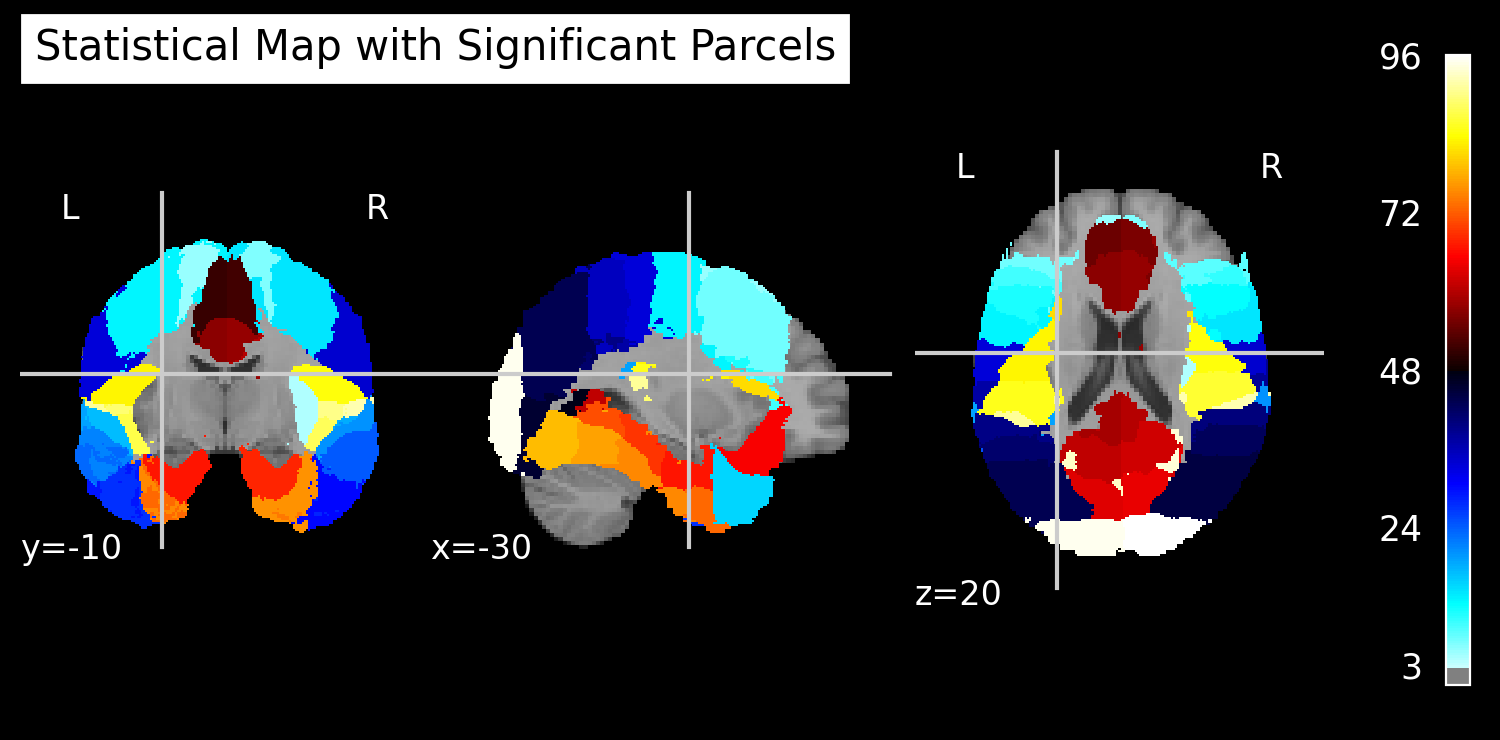

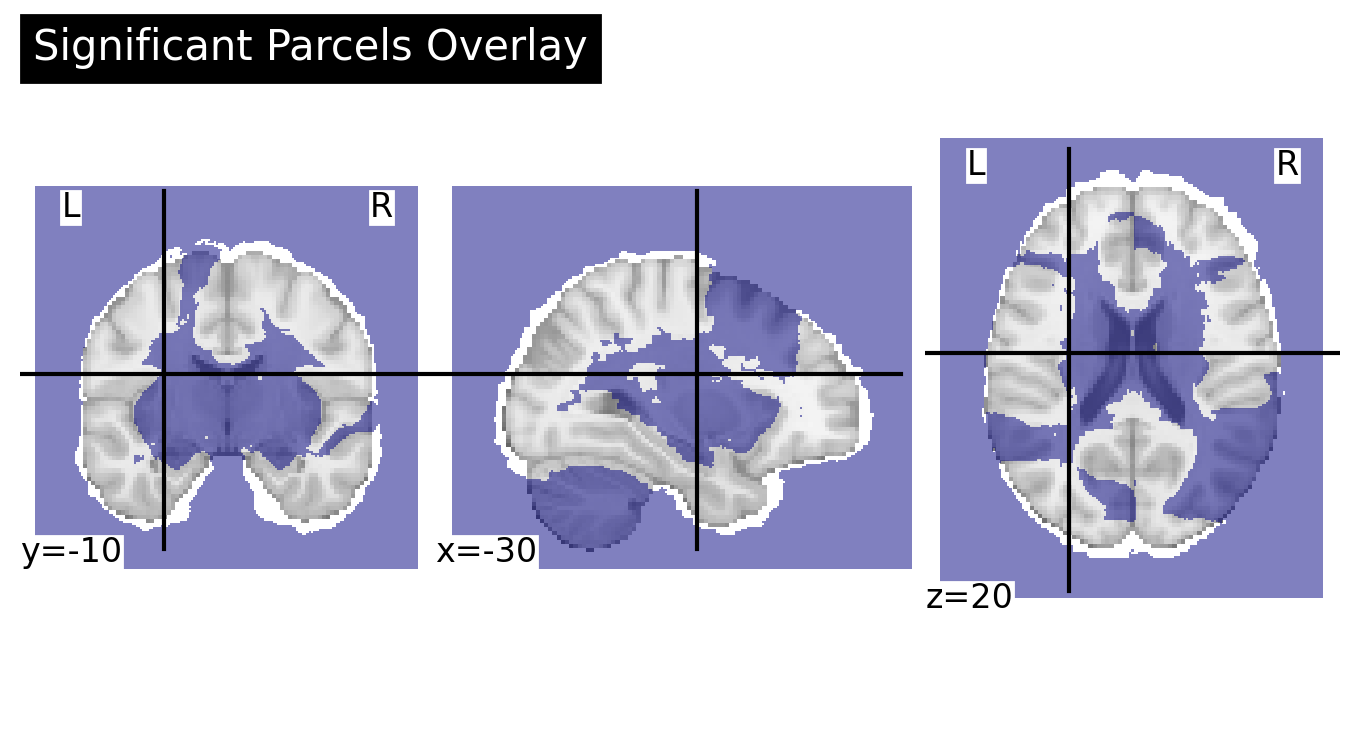

In [ ]:
# Load statistical map (replace 'stat_map.nii' with your actual map)
stat_map_img = image.load_img(atlas_filename)

# Plot statistical map with significant parcels overlaid
plotting.plot_stat_map(stat_map_img,
                       threshold=3,  # Example threshold
                       display_mode='ortho',
                       title="Statistical Map with Significant Parcels",
                       cut_coords=[-30, -10, 20],
                       black_bg=True)

plotting.plot_roi(mask_img,
                  title="Significant Parcels Overlay",
                  display_mode='ortho',
                  cut_coords=[-30, -10, 20],
                  alpha=0.5)  # Transparency for overlay effect
plt.show()


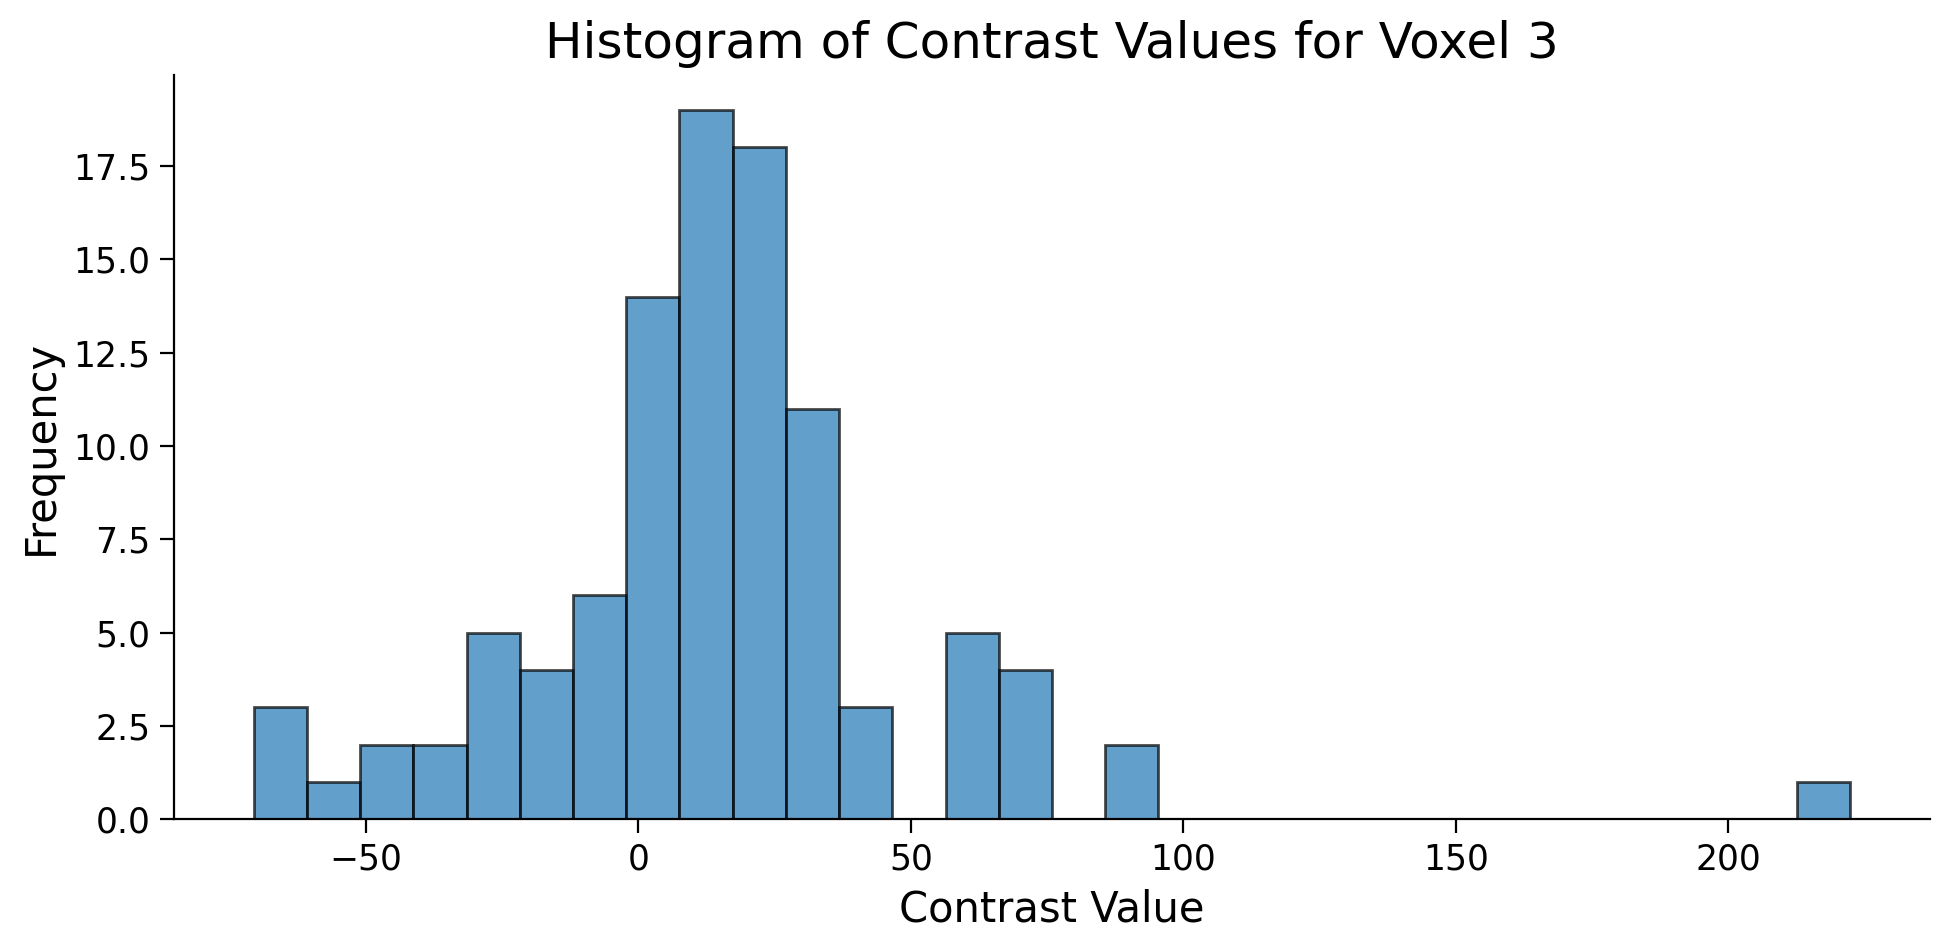

In [ ]:
 # Plotting Contrast Maps
 # Contrast maps represent the difference between conditions (e.g., neutral events in win vs. loss blocks) across subjects.
 import matplotlib.pyplot as plt
import numpy as np

# Example: Plot contrast maps for a specific voxel across all subjects
voxel_index = 3  # Replace with your voxel index of interest

# Extract contrast values for this voxel
contrast_values = contrast_maps[:, voxel_index]

# Plot the contrast values
plt.figure(figsize=(10, 5))
plt.hist(contrast_values, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Histogram of Contrast Values for Voxel {voxel_index}')
plt.xlabel('Contrast Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:
contrast_maps.shape

(100, 360)

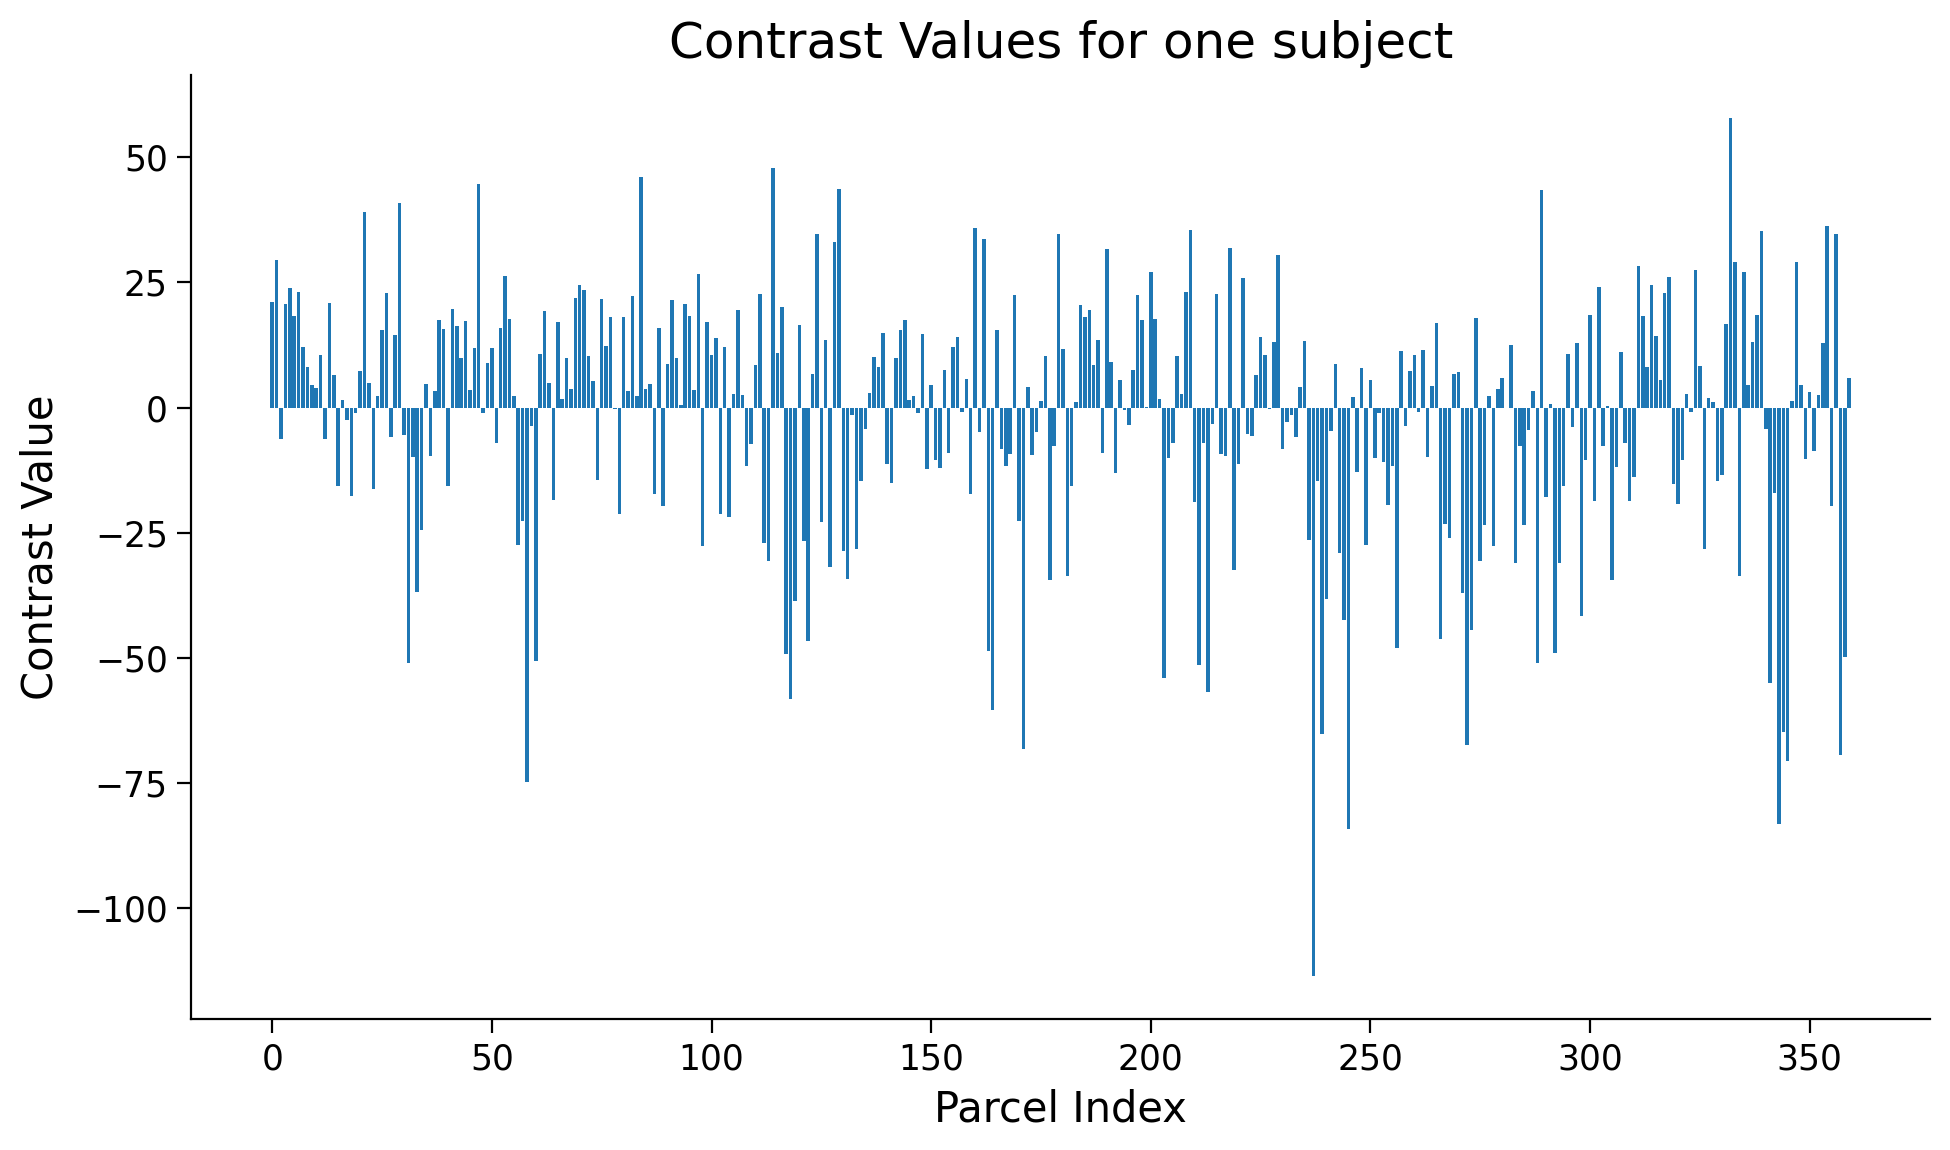

In [ ]:
"""
To make sense of the contrast map, you should visualize the results. Common tools and methods for visualizing neuroimaging data include:

Brain Imaging Software: Use software like FSL, SPM, or MRIcron to overlay contrast values on a brain template or anatomical image.
Matplotlib: For a simple 2D representation, you can use Python's plotting libraries.



"""


import matplotlib.pyplot as plt

# Plotting the contrast values
plt.figure(figsize=(10, 6))
plt.bar(range(len(contrast_maps[0,:])), contrast_maps[0,:])
plt.xlabel('Parcel Index')
plt.ylabel('Contrast Value')
plt.title('Contrast Values for one subject')
plt.show()


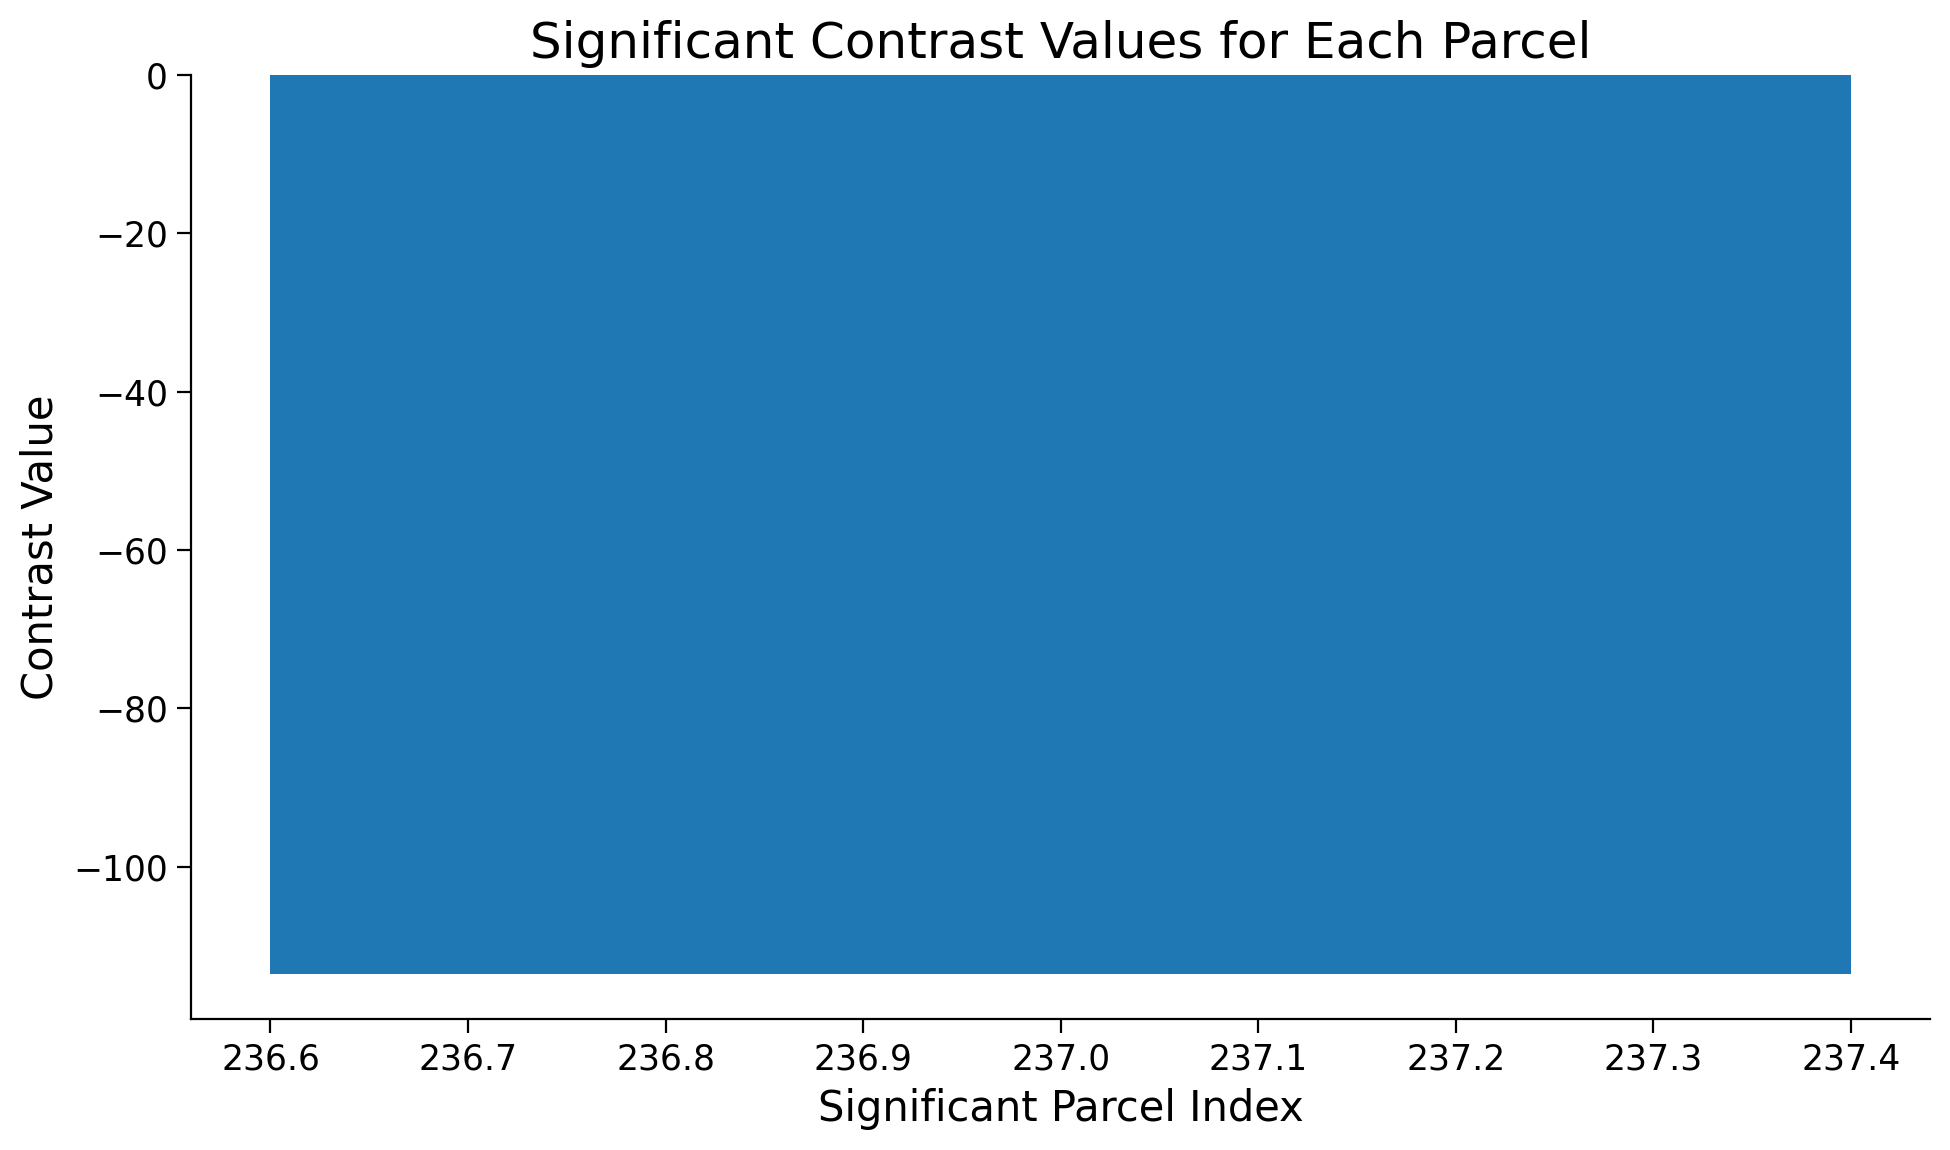

In [ ]:
"""
Thresholding
To focus on significant contrast values, you might apply a threshold. This is often used in conjunction with statistical tests to determine which values are significantly different from zero.

"""

# Define a threshold for significance
threshold = 100  # This value depends on your criteria

# Identify parcels above the threshold
significant_parcels = np.abs(contrast_maps[0,:]) > threshold
significant_contrast_map = contrast_maps[0,:][significant_parcels]

# Optionally, plot significant parcels
plt.figure(figsize=(10, 6))
plt.bar(np.where(significant_parcels)[0], contrast_maps[0,:][significant_parcels])
plt.xlabel('Significant Parcel Index')
plt.ylabel('Contrast Value')
plt.title('Significant Contrast Values for Each Parcel')
plt.show()


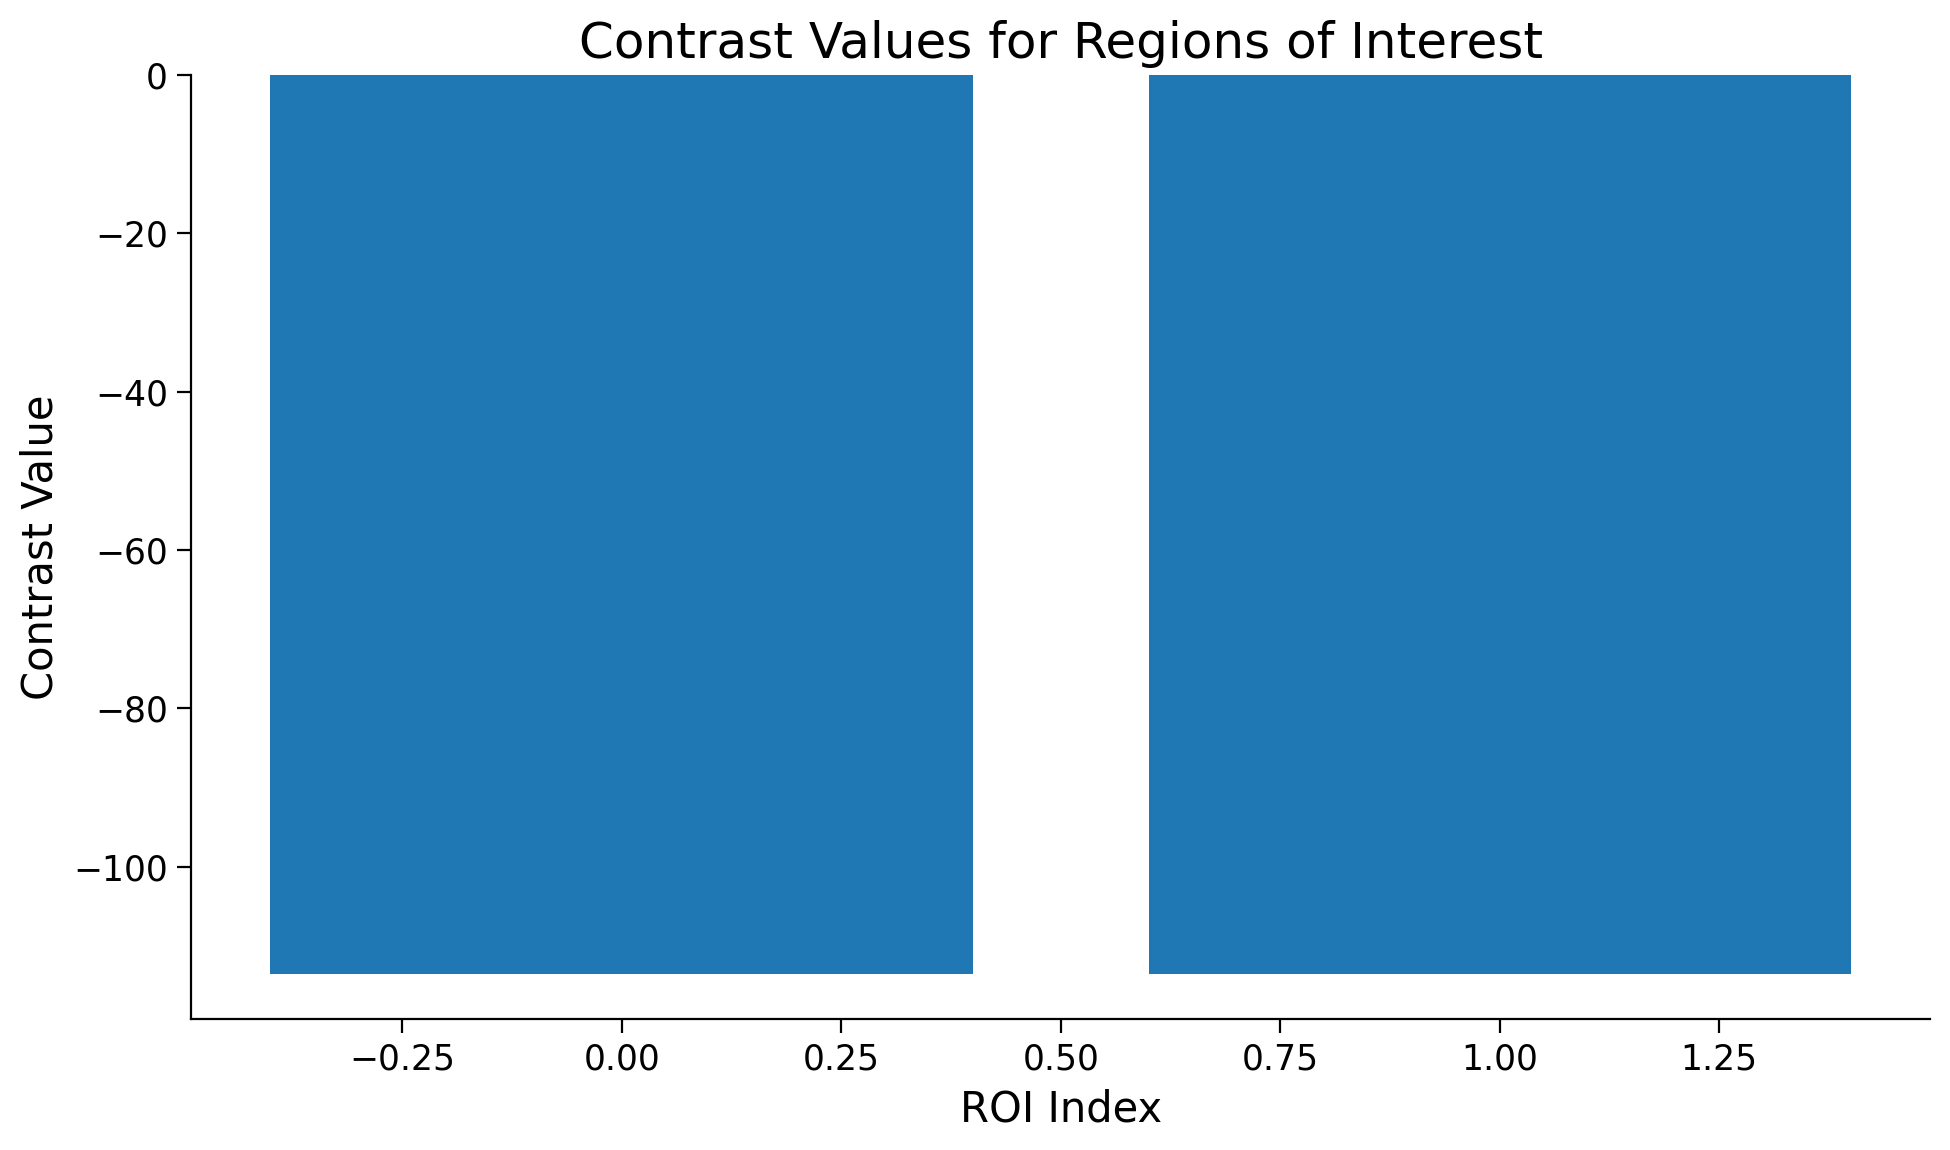

In [ ]:
# Define indices for regions of interest (example)

"""
Region of Interest (ROI) Analysis
If you have specific regions of interest, you can extract and analyze contrast values within these regions.


"""
roi_indices = significant_parcels
#[1, 2, 3, 10]  # Replace with actual indices of interest

# Extract contrast values for these ROIs
roi_contrast_values = contrast_maps[0,:][roi_indices]

# Analyze or visualize ROI contrast values
plt.figure(figsize=(10, 6))
plt.bar(roi_indices, roi_contrast_values)
plt.xlabel('ROI Index')
plt.ylabel('Contrast Value')
plt.title('Contrast Values for Regions of Interest')
plt.show()


# RSA

In [ ]:
contrast_maps.shape

(100, 360)

In [ ]:
import numpy as np

# Example contrast maps for two conditions
# Shape: (n_subjects, n_rois, n_conditions)
n_subjects = 100
n_rois = 360
#contrast_maps = np.random.rand(n_subjects, n_rois, 2)  # Random data for demonstration

# Separate contrast maps for the two conditions
beta_maps_win = L2_betas[:, :, 1]  # Contrast maps for neutral_win
beta_maps_loss = L2_betas[:, :, 2]  # Contrast maps for neutral_loss


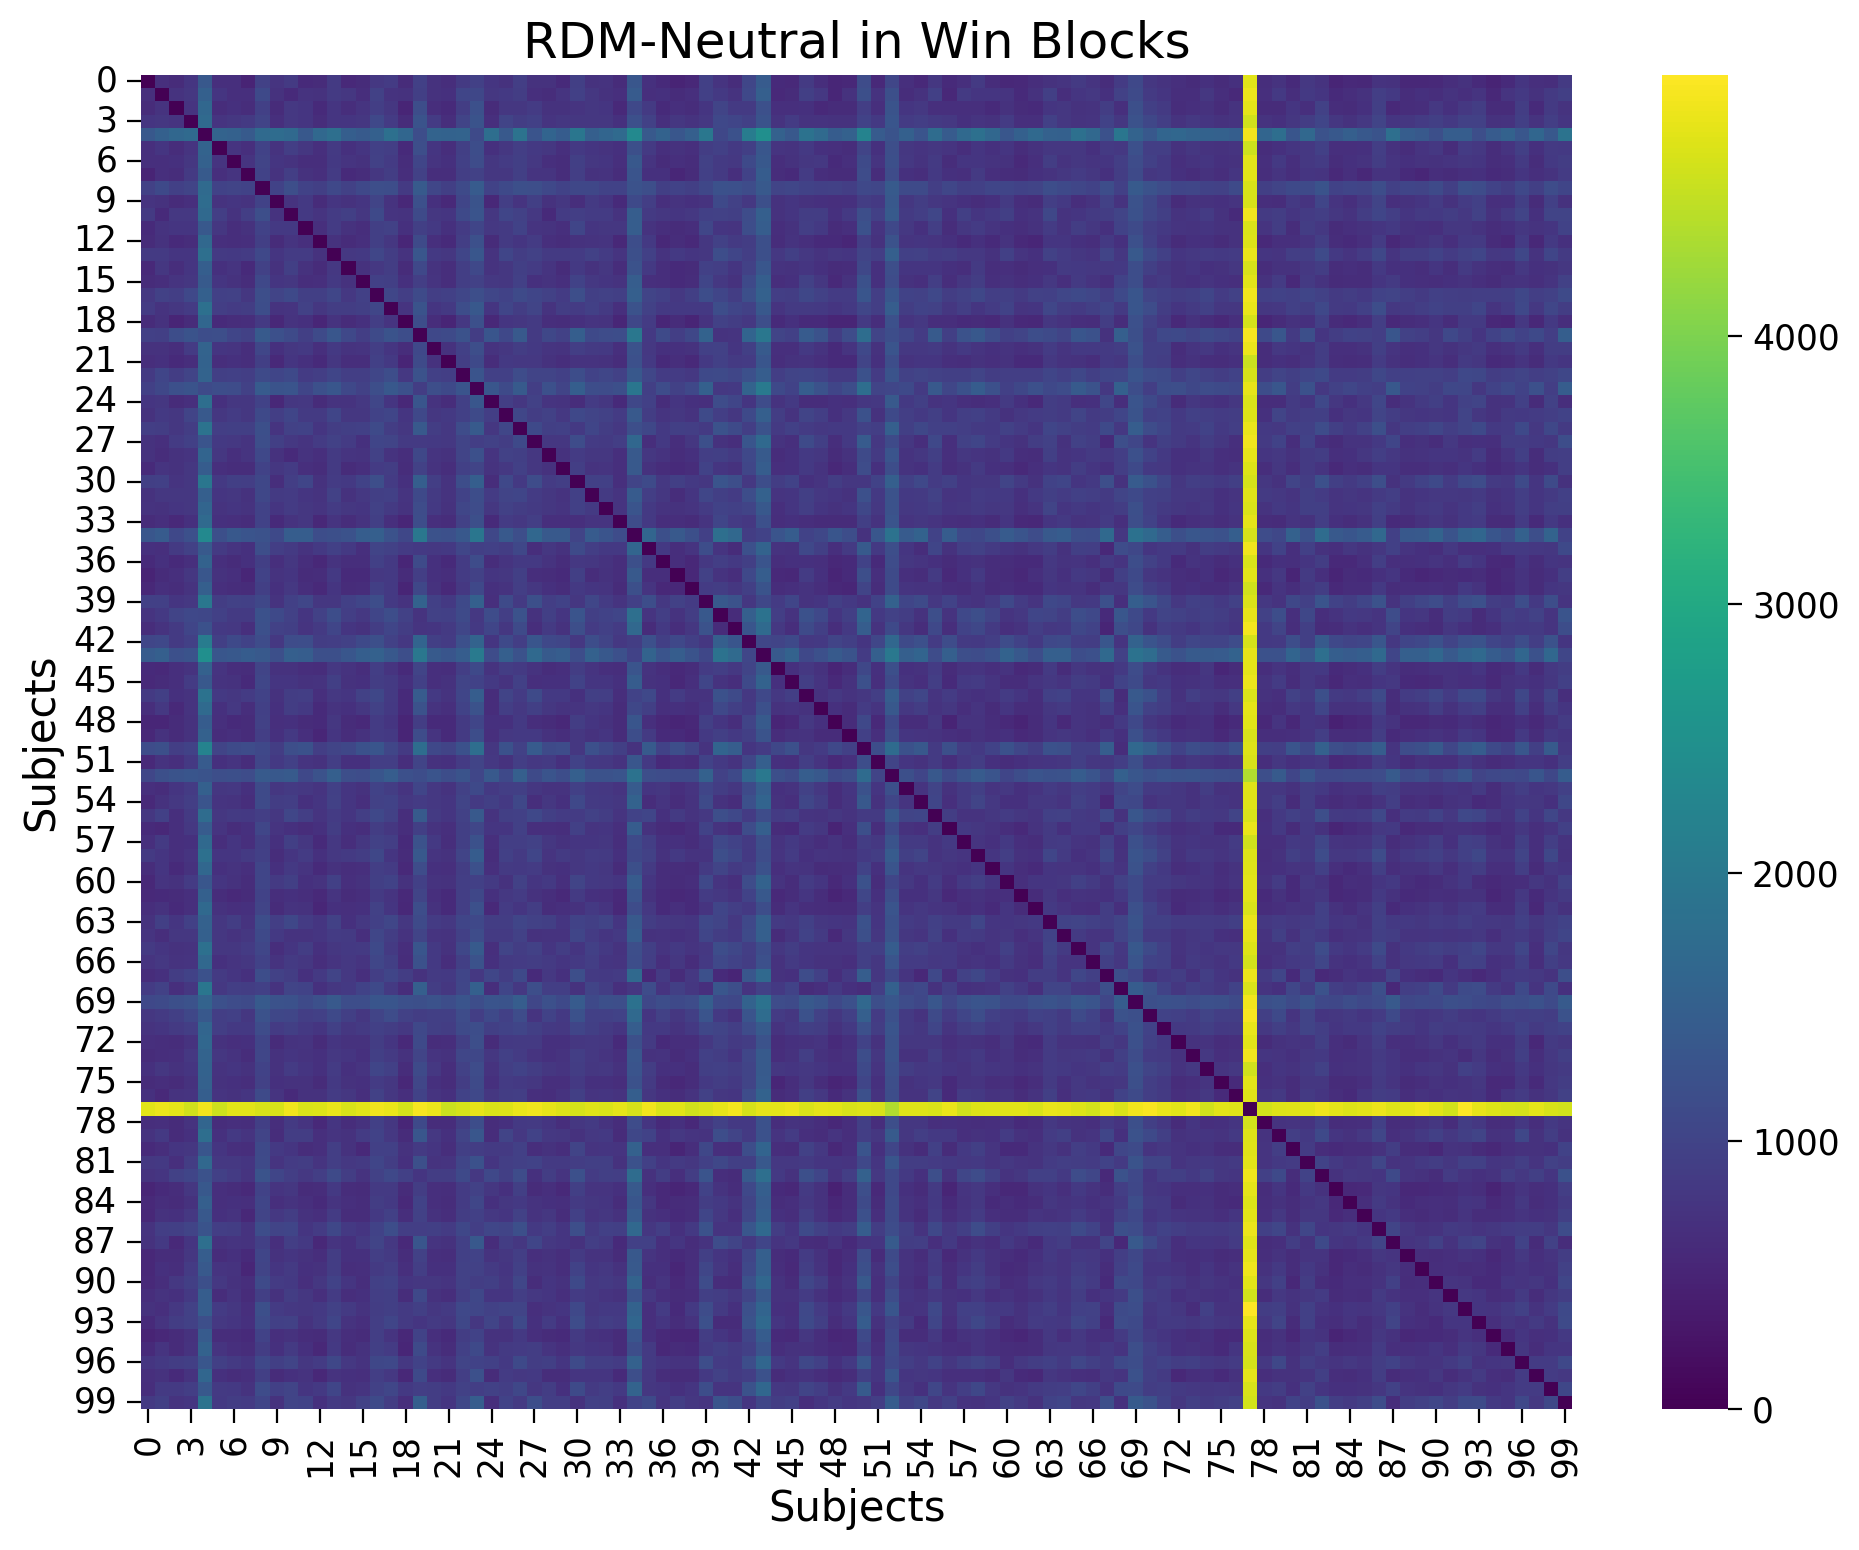

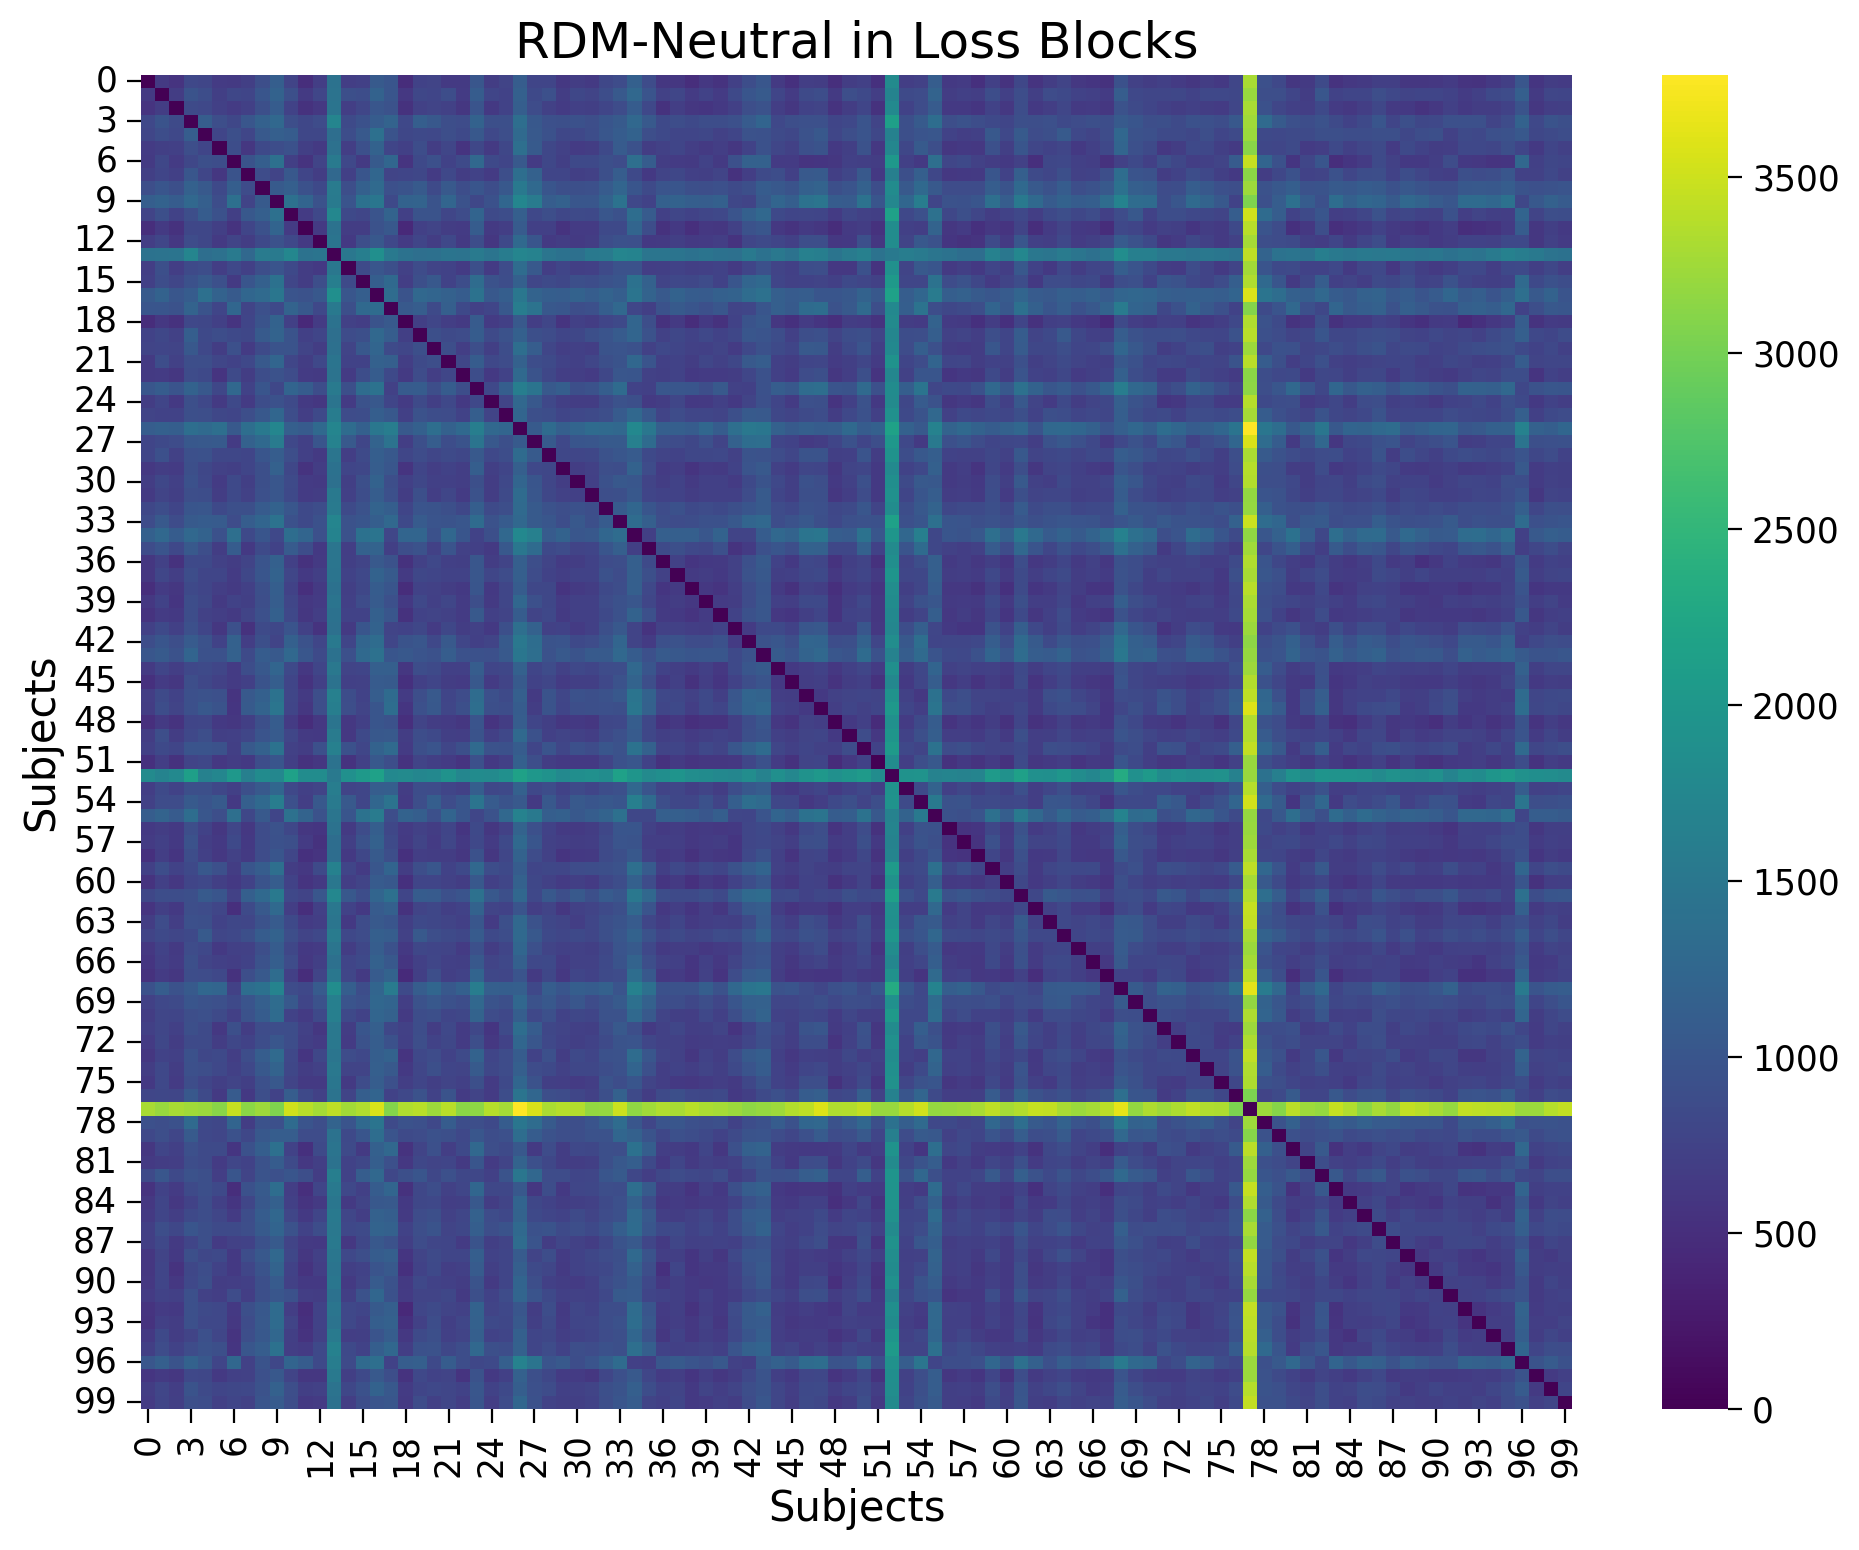

In [ ]:
from scipy.spatial.distance import pdist, squareform

def compute_rdm(beta_maps):
    """
    Compute the RDM for given contrast maps.

    Args:
        contrast_maps (numpy.ndarray): Contrast maps of shape (n_subjects, n_rois).

    Returns:
        numpy.ndarray: RDM matrix of shape (n_subjects, n_subjects).
    """
    # Compute pairwise dissimilarities (Euclidean distance) between subjects
    distances = pdist(beta_maps, metric='euclidean')
    rdm = squareform(distances)

    return rdm


import seaborn as sns
import matplotlib.pyplot as plt

def plot_rdm(rdm, condition_labels,title):
    """
    Plot the RDM using a heatmap.

    Args:
        rdm (numpy.ndarray): RDM matrix.
        condition_labels (list): List of condition labels for axis ticks.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(rdm, cmap='viridis', annot=False)
    plt.title(title)
    plt.xlabel('Subjects')
    plt.ylabel('Subjects')
    plt.show()

# Compute RDM for neutral_win and neutral_loss conditions
rdm_win = compute_rdm(beta_maps_win)
rdm_loss = compute_rdm(beta_maps_loss)

# Plot RDMs
plot_rdm(rdm_win, ['Subject']*n_subjects,'RDM-Neutral in Win Blocks')  # Plot RDM for neutral_win condition
plot_rdm(rdm_loss, ['Subject']*n_subjects,'RDM-Neutral in Loss Blocks')  # Plot RDM for neutral_loss condition


In [ ]:
contrast_maps.shape

(100, 360)

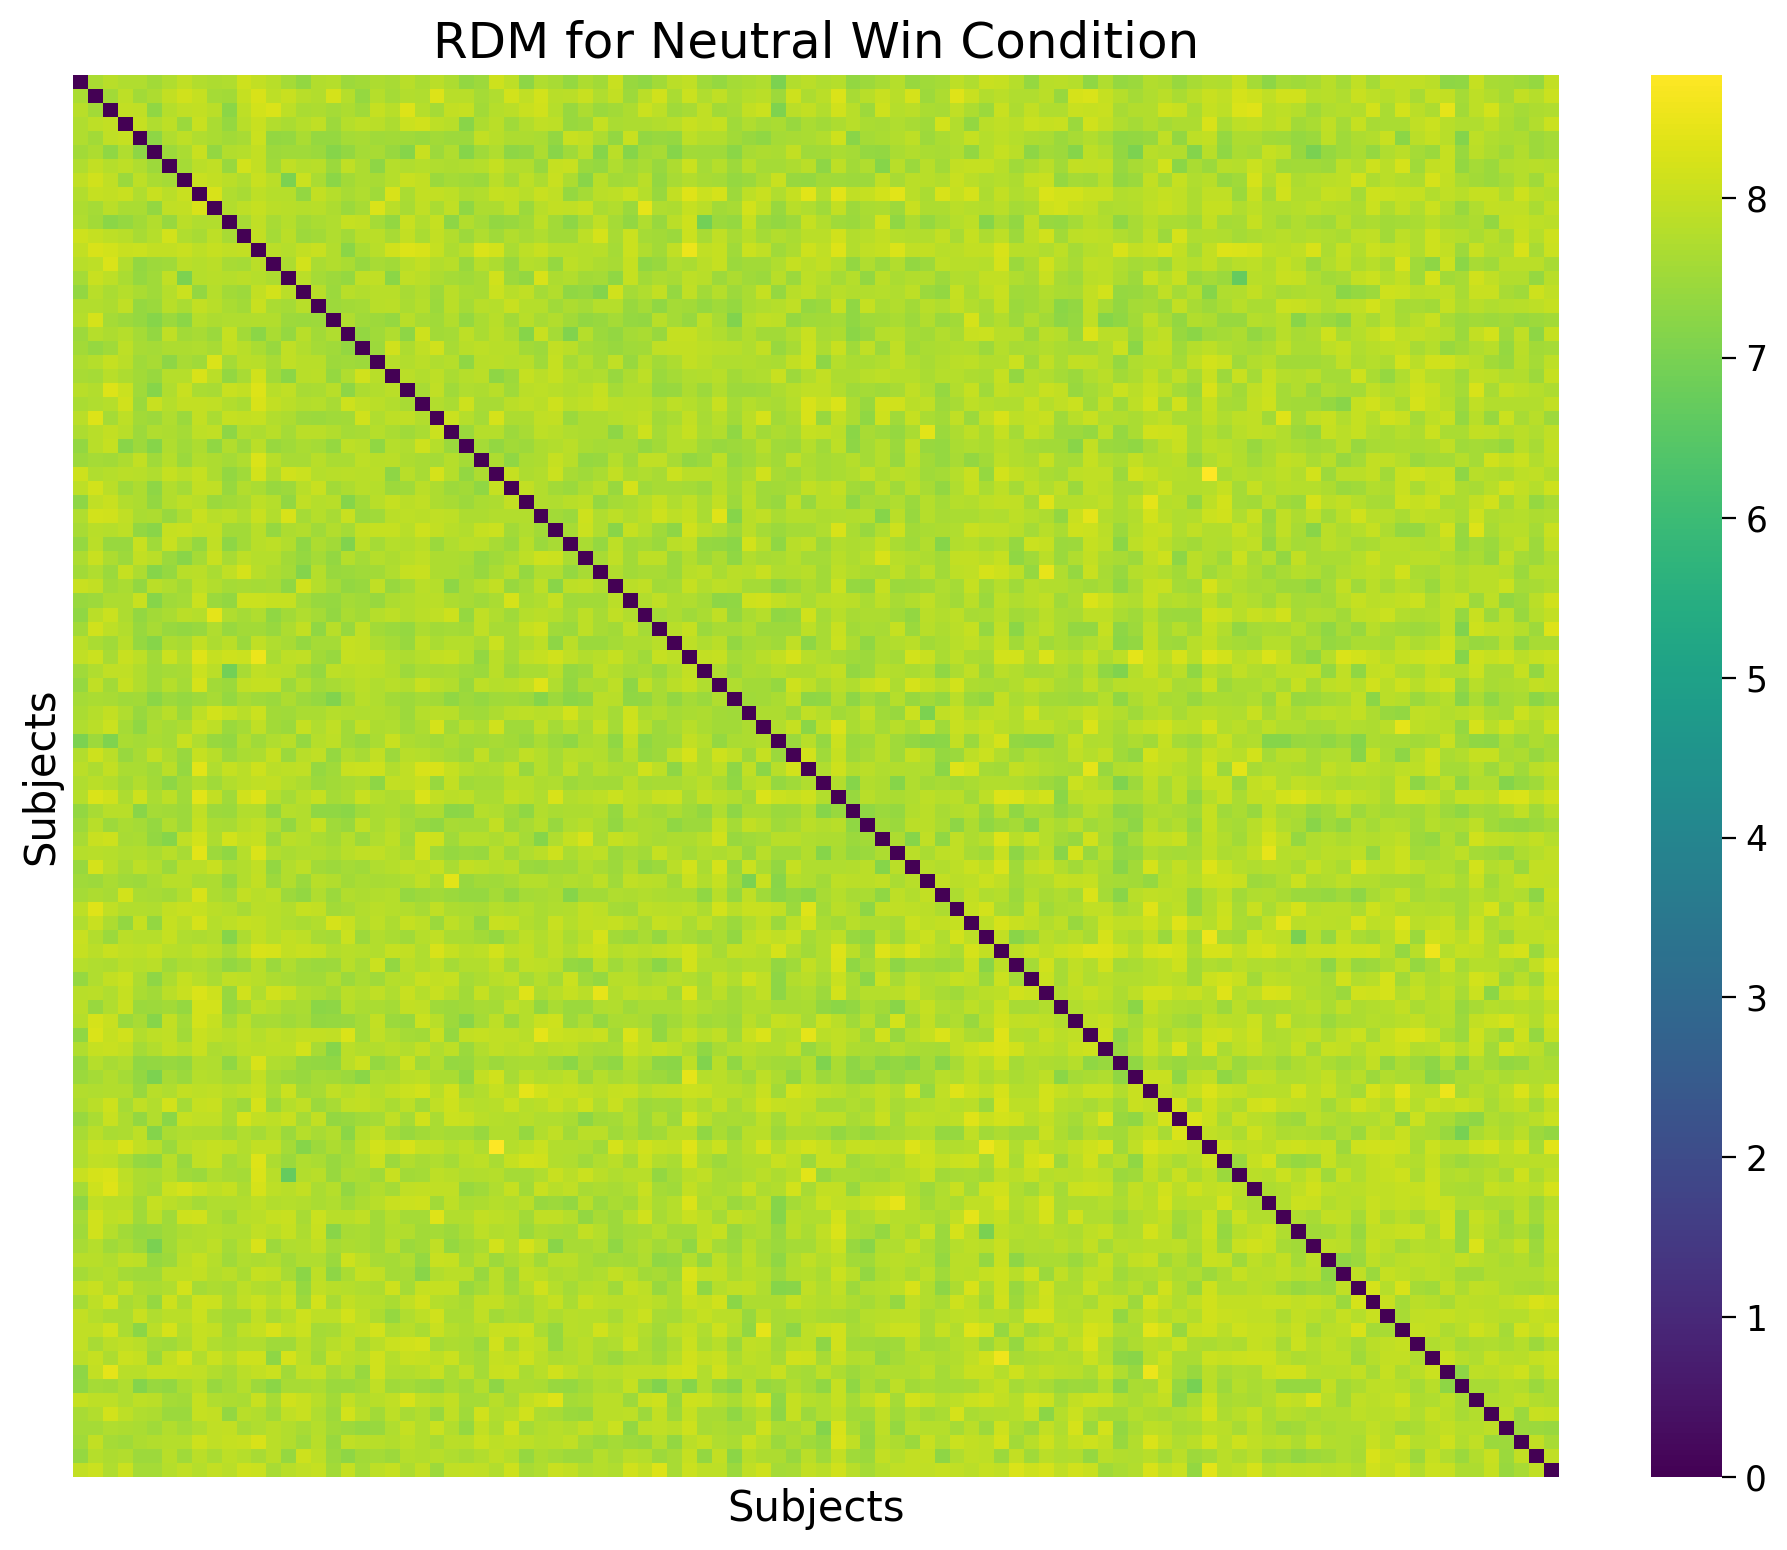

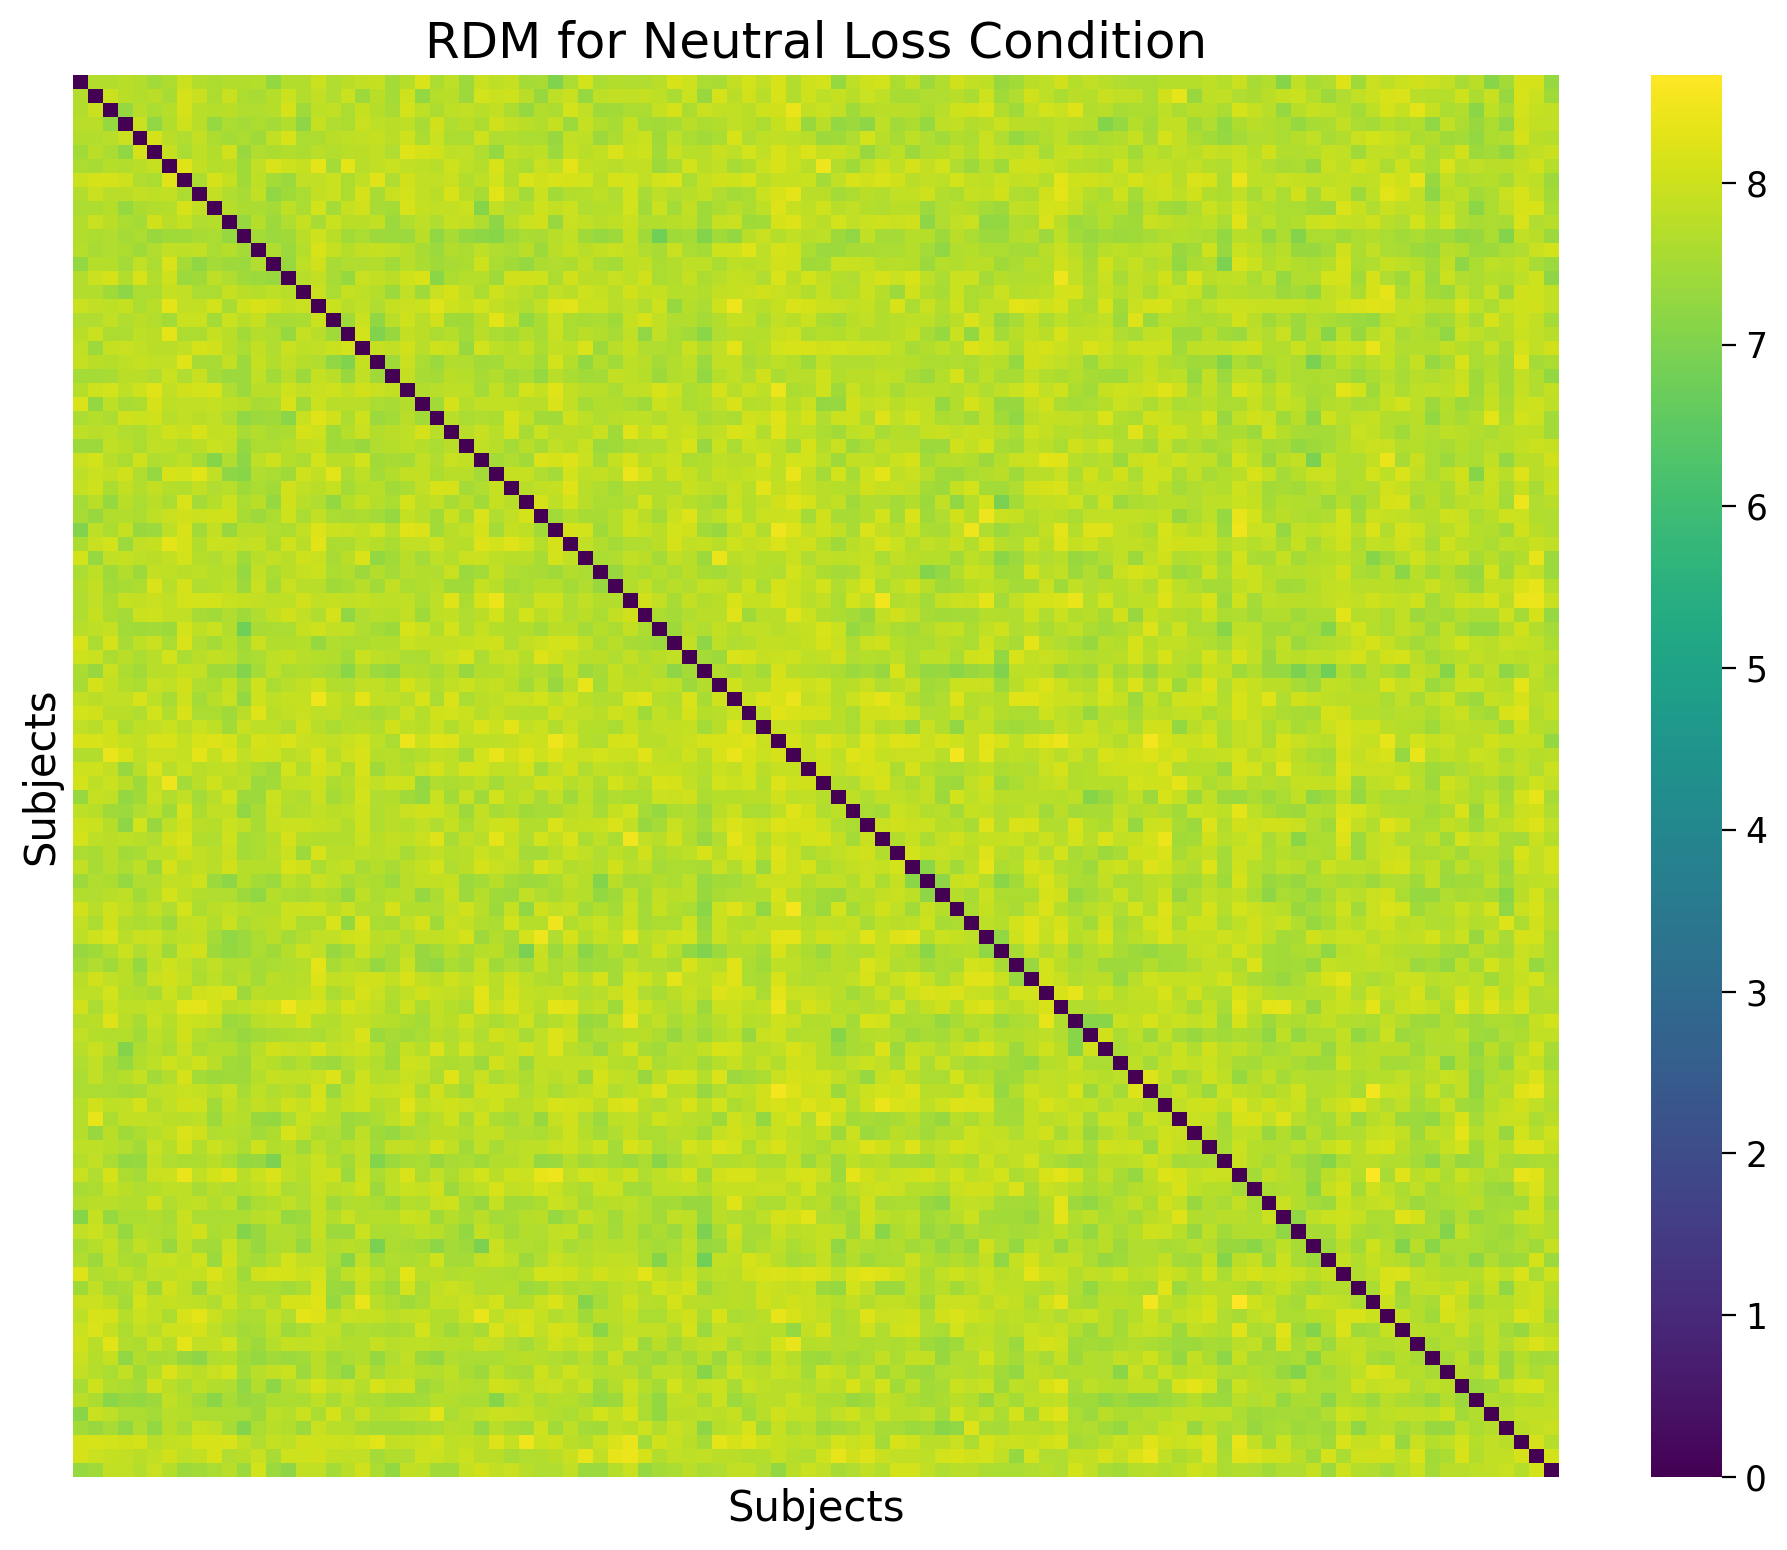

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

def compute_rdm(contrast_maps):
    """
    Compute the Representational Dissimilarity Matrix (RDM) for given contrast maps.

    Args:
        contrast_maps (numpy.ndarray): Contrast maps of shape (n_subjects, n_rois).

    Returns:
        numpy.ndarray: RDM matrix of shape (n_subjects, n_subjects).
    """
    # Compute pairwise dissimilarities (Euclidean distance) between subjects
    distances = pdist(contrast_maps, metric='euclidean')
    rdm = squareform(distances)

    return rdm

def plot_rdm(rdm, title):
    """
    Plot the RDM using a heatmap.

    Args:
        rdm (numpy.ndarray): RDM matrix.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(rdm, cmap='viridis', annot=False, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel('Subjects')
    plt.ylabel('Subjects')
    plt.show()

# Example contrast maps for different conditions (replace with your actual data)
n_subjects = 100
n_rois = 360
contrast_maps_win = np.random.rand(n_subjects, n_rois)  # Example data for neutral_win
contrast_maps_loss = np.random.rand(n_subjects, n_rois)  # Example data for neutral_loss

# Compute RDMs
rdm_win = compute_rdm(contrast_maps_win)
rdm_loss = compute_rdm(contrast_maps_loss)

# Plot RDMs
plot_rdm(rdm_win, 'RDM for Neutral Win Condition')
plot_rdm(rdm_loss, 'RDM for Neutral Loss Condition')


In [ ]:
from scipy.spatial.distance import cdists

def compute_rsa(contrast_maps1, contrast_maps2):
    """
    Compute the Representational Similarity Analysis (RSA) between two sets of contrast maps.

    Args:
        contrast_maps1 (numpy.ndarray): Contrast maps of shape (n_subjects, n_rois) for condition 1.
        contrast_maps2 (numpy.ndarray): Contrast maps of shape (n_subjects, n_rois) for condition 2.

    Returns:
        numpy.ndarray: Similarity matrix of shape (n_subjects, n_subjects).
    """
    # Compute pairwise similarities (correlation distance) between subjects
    similarities = 1 - cdist(contrast_maps1, contrast_maps2, metric='correlation')
    return similarities

def plot_rsa(rsa_matrix, title):
    """
    Plot the RSA matrix using a heatmap.

    Args:
        rsa_matrix (numpy.ndarray): RSA matrix.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(rsa_matrix, cmap='viridis', annot=False, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel('Subjects')
    plt.ylabel('Subjects')
    plt.show()

# Example RSA computation
rsa_matrix = compute_rsa(contrast_maps_win, contrast_maps_loss)

# Plot RSA matrix
plot_rsa(rsa_matrix, 'RSA Matrix between Neutral Win and Neutral Loss Conditions')


ImportError: cannot import name 'cdists' from 'scipy.spatial.distance' (/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py)

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [ ]:
my_exp = 'GAMBLING'
my_subj = subjects[0]
my_run = 0

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions.

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [ ]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)


  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


story_activity = average_frames(data, evs, my_exp, 'story')
math_activity = average_frames(data, evs, my_exp, 'math')
contrast = lf_activity - rf_activity  # difference between left and right hand movement

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(lf_activity,label='left foot')
plt.plot(rf_activity,label='right foot')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [ ]:
df = pd.DataFrame({'lf_activity' : lf_activity,
                   'rf_activity' : rf_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='lf_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rf_activity', data=df, hue='hemi',ax=ax2)
plt.show()

In [ ]:
a = np.load('/content/hcp_task/subjects/100307/MOTOR/tfMRI_MOTOR_LR/data.npy')
a.shape

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans).


Let us boost thee stats by averaging across all subjects and runs.

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, 'lf')
    rf_activity = average_frames(data, evs, my_exp, 'rf')

    contrast = lf_activity - rf_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [ ]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)